In [1]:
from functions import *
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_filename = '../data/mva_sales.csv'
data_column = 'Used'
date_column = 'Fecha'

data = pd.read_csv(data_filename)
data.head()

,Year,Month,New,Used,Total Sales New,Total Sales Used
0,2002,JAN,31106,49927,755015820,386481929
1,2002,FEB,27520,50982,664454223,361353242
2,2002,MAR,34225,58794,805666244,419385387
3,2002,APR,36452,59817,846368297,433061150
4,2002,MAY,37359,60577,855005784,442569410


In [3]:
# Arreglo la fecha a aun formato legible
data['Month'] = data['Month'].apply(lambda x: x.capitalize())
data['Year'] = data['Year'].astype(str)
data['Fecha'] = data['Month'] +"-"+ data['Year']
data['Fecha'] = pd.to_datetime(data['Fecha'], format="%b-%Y")
sales = data[[date_column,data_column]].copy()
# Convierto la columna Fecha en índice
sales.index = sales[date_column]
del sales[date_column]
sales.sort_index(inplace=True)

In [4]:
sales.index.freq = 'MS'
sales = sales[sales.index < '2020-01-01']

sales.shape

(216, 1)

In [5]:
sales.isna().sum()

Used    0
dtype: int64

In [6]:
# Split into train and test set
steps = 24
sample = len(sales) - steps
sales_train = sales[:sample]
sales_test = sales[sample:]

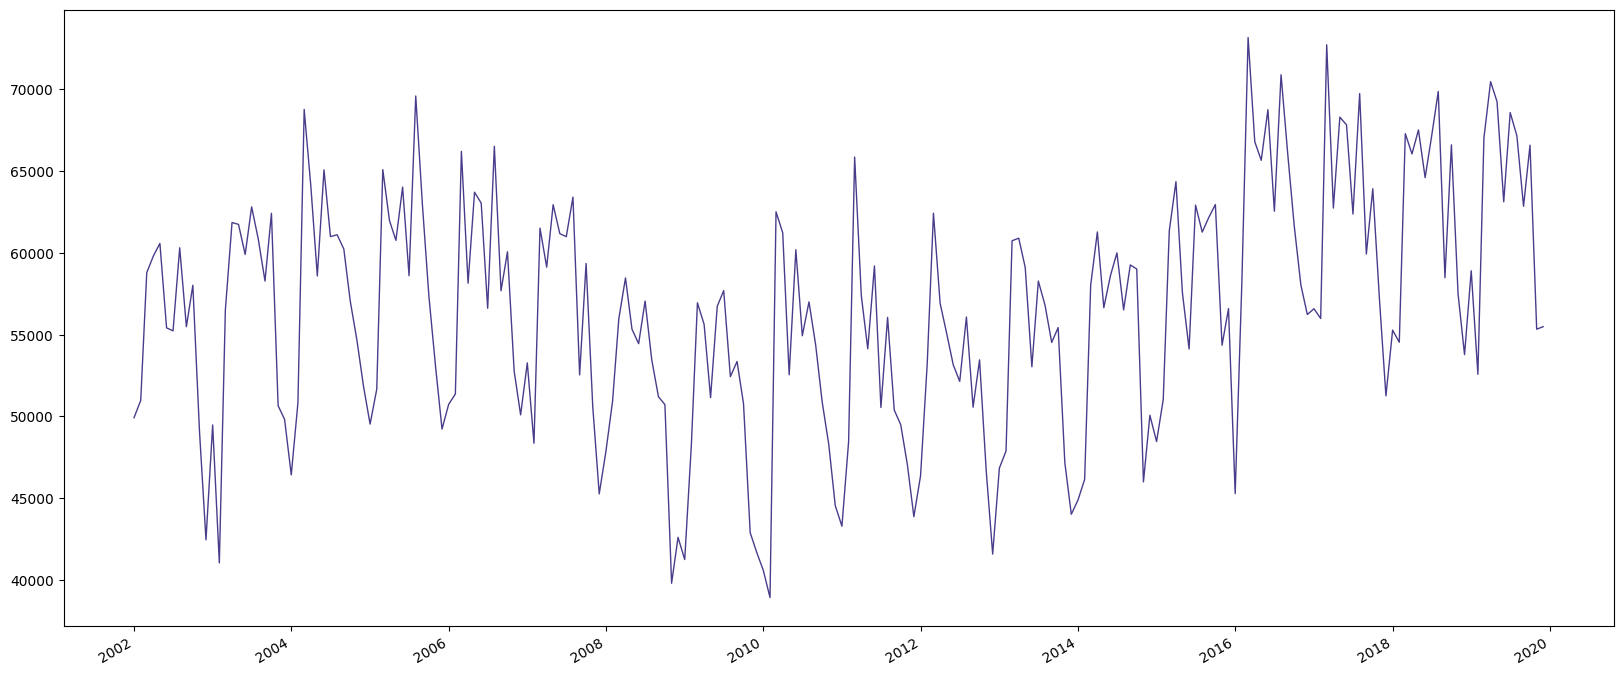

In [7]:
# Grafico la serie y obtengo un primera visualización de los datos
plt.figure(figsize=(20, 8))
plt.plot(sales[data_column],linewidth = 1, color='darkslateblue')
plt.xticks(rotation=30,ha='right')
plt.show()

## XGBoost

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

<Axes: title={'center': 'Train / Test Sales'}, xlabel='Fecha'>

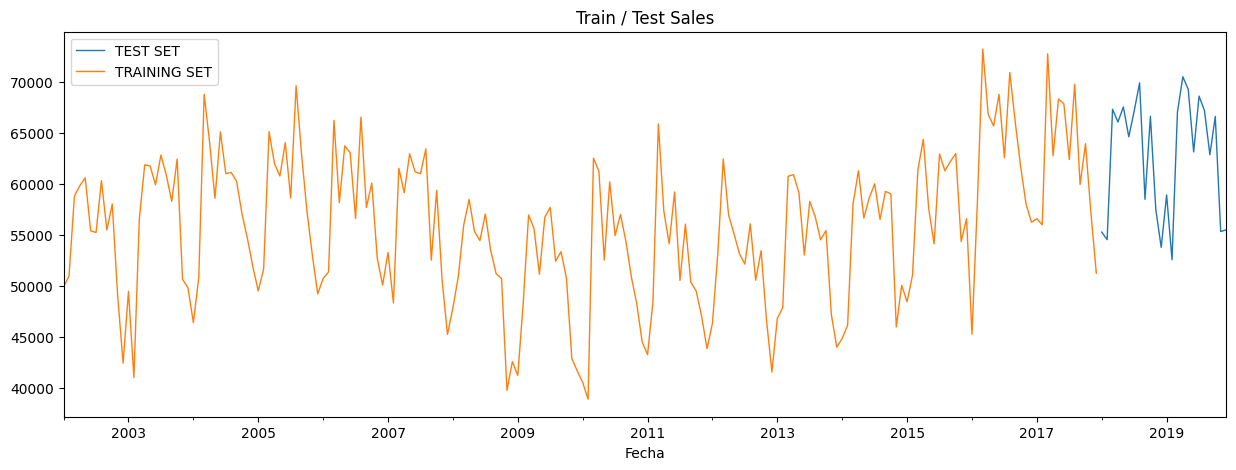

In [9]:
sales_test.rename(columns={data_column:'TEST SET'}).join(sales_train.rename(columns={data_column:'TRAINING SET'}), how='outer').plot(figsize=(15,5),title='Train / Test Sales', style='-',lw=1)

In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
# Set the window size
window_size = 24

# Split data into training and test sets
X_train, y_train = create_lagged_features(sales_train[data_column].values, window_size)


X_train, y_train = create_features(sales_train, label=data_column)
X_test, y_test = create_features(sales_test, label=data_column)

/home/juancarlos/Documents/dev/sales_forecasting/experiments/functions.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/home/juancarlos/Documents/dev/sales_forecasting/experiments/functions.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
/home/juancarlos/Documents/dev/sales_forecasting/experiments/functions.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [11]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345)

In [12]:
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1,verbose=1)
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=12345, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [13]:
sales_test['Predicciones'] = xgb_grid_search.best_estimator_.predict(X_test)
sales_all = pd.concat([sales_test, sales_train], sort=False)

/tmp/ipykernel_195498/1317185890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_test['Predicciones'] = xgb_grid_search.best_estimator_.predict(X_test)


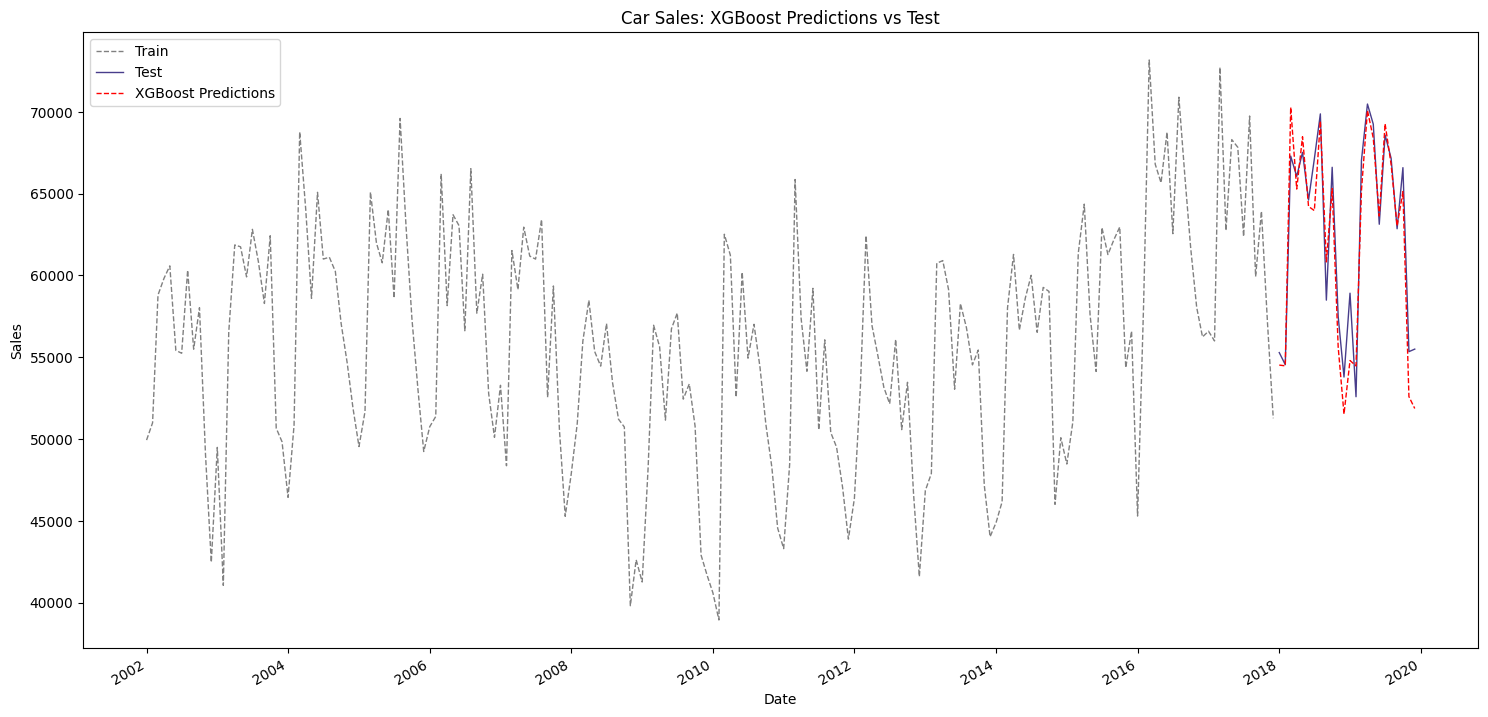

In [14]:
PlotPredictions([
    (sales_train.index,sales_train[data_column],'Train','--','gray'),
    (sales_test.index,sales_test[data_column],'Test','-','darkslateblue'),
    (sales_test.index,sales_test['Predicciones'],'XGBoost Predictions','--','red')],
    'Car Sales: XGBoost Predictions vs Test')

In [15]:
from sklearn.metrics import mean_absolute_percentage_error
xgb_mape = mean_absolute_percentage_error(sales_test[data_column], sales_test['Predicciones'])
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')

XGBoost MAPE:		2.47%
